# MNIST 실습 (Pytorch)

# 1. 환경 설정

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

*먼저, GPU 사용 여부를 결정합니다.*

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda" )
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False

print(device)

cuda


# 2. 데이터 준비

- 토치에서 random seed를 고정하기 위해 manual_seed()를 사용한다.
- random seed를 고정한다는 말은 동일한 셋트의 난수를 생성할 수 있게 하는 것이다.

In [3]:
seed = 1
torch.manual_seed(seed)

데이터를 불러오기 전에 데이터 전처리 과정을 미리 정의하기

---

torchvision.transforms 모듈은
1. pre-processing
2. data augmentation
아래 링크 참고하기

https://wikidocs.net/194919

---

ToTensor() 사용 이유

1. 배열구조 변환
이미지 또는 넘파이 배열은 HWC순이다.
ToTensor()를 사용하면 토치의 배열 구조인 CHW로 변환해준다.

2. 값의 크기를 조정(scaling)
0-255 → 0-1


In [4]:
transform = transforms.Compose([
    transforms.ToTensor() # 텐서로 변환
])

Train, validation, test data를 설정합시다.

---

Dataset 은 샘플과 정답(label)을 저장하고
dataset 클래스는 __len__()과 __getitem__()이 꼭 있어야 함!

DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌉니다.
- 이때 중요한 것은 batch 크기 데이터를 불러오는 걸 해준다.

- shuffle = true : each epoch 마다 데이터 학습되는 순서가 변경된다.

아래 링크 참고하기
https://wikidocs.net/156998

---
torch.utils.data.random_split()함수
- 데이터를 random 하게 split

In [25]:
batch_size = 32
test_batch_size = 1024

train_ratio = 0.8
validation_ratio = 0.2

mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('../data', train=False, download=True, transform=transform)
len_mnist_train = len(mnist_train)
train_size = int(len_mnist_train * train_ratio)
validation_size = int(len_mnist_train * validation_ratio)

train_dataset, validation_dataset = torch.utils.data.random_split(mnist_train, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=test_batch_size, shuffle=True)

*다운받은 data를 확인해보겠습니다.*

In [27]:
# 해당 셀을 계속해서 실행하면 next()함수로 인해 다음 데이터가 반환된다.
# 그래서 출력 결과가 매번 다를 것이다.
it_train = iter(train_loader)
img, label = next(it_train) # train loader에서 하나씩 꺼내려면 iter를 사용하면 된다.
#train x, train y

print(img.shape) # torch.Size는 순서대로 ([batch_size, color, height, width])를 의미합니다.
print(label)
print(f"배치 크기: {len(label)}")

torch.Size([32, 1, 28, 28])
tensor([3, 4, 7, 2, 9, 3, 9, 5, 8, 9, 7, 7, 7, 1, 9, 5, 7, 0, 3, 3, 4, 3, 7, 3,
        4, 8, 7, 9, 4, 3, 5, 3])
배치 크기: 32




*batch_size와 color 차원을 제거하고 이미지를 랜더링 해봅시다.*

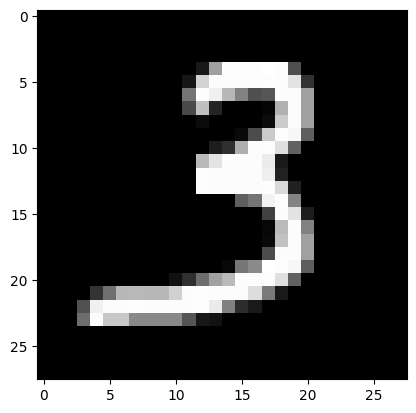

tensor(3)


In [28]:
index = 0
img_show = img[index, 0, :, :] # 암기하기     [ batchsize, channel, height, width ]
plt.imshow(img_show, 'gray') # plt.imshow() 함수는 좌표평면 위에 이미지를 출력
plt.show() # 이건 imshow() 다음에 꼭 사용하기
print(label[index])

# 3. 모델 정의

모델 1은
- 레이어1: 16개의 노드
- 레이어2: 10개의 노드

이때 torch.nn.Module을 상속받아야 한다. (상속: 어떤 클래스를 만들 때 다른 클래스의 기능을 가져오는 것)

이때 __init()__과 forward()를 override해야한다. (override: 부모 클래스인 torch.nn.Module에서 정의한 메소드를 자식 클래스에서 변경하는 것)
- __init()__ : layer를 정의하는 곳
- forward() : 모델에서 실행되는 계산을 정의. backward()는 토치에서 알아서 해준다!

---

forward() 함수
- 보면, view() 함수를 사용한다. view는 reshape하는 함수이다. 링크를 참고해라! (https://jimmy-ai.tistory.com/151)
- F.log_softmax()함수는 log(softmax)랑 같은 개념. softmax 사용 시 vanishing gradient 문제 때문에, 이걸 사용하는 경우가 많음.

In [57]:
class NeuralNetwork(torch.nn.Module): # 토치에서는 모델을 정의할 때 class로 만들어야한다.
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # Layer 정의
        self.fc1 = nn.Linear(784, 16)
        self.fc2 = nn.Linear(16, 10)

  # Layer 쌓기
    def forward(self, x):
        x = x.float() # x는 입력받는 이미지를 의미함
        h1 = F.relu(self.fc1(x.view(-1, 784))) # import torch.nn.functional as F
        h2 = self.fc2(h1)
        return F.log_softmax(h2, dim=1)

In [58]:
model = NeuralNetwork().to(device) # to(device)로 모델 gpu에 보내기

# 4. 모델 학습

아래는 enumerate의 실행 결과

```
list1 = [1, 2, 3, 4, 5, 6, 10]
for idx, data in enumerate(list1):
    print(idx, data)

0 1
1 2
2 3
3 4
4 5
5 6
6 10
```




*네트워크를 학습시키기 위해서 train 함수를 정의합니다.*

In [51]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    flag = True
    for batch_idx, (data, target) in enumerate(train_loader): # data를 하나씩 주는 게 아니라 batch 크기만큼 준다. 그래서 batch_idx를 사용하는 것이다.
        data, target = data.to(device), target.to(device) # 데이터를 target device에 올려야 한다.
        optimizer.zero_grad() # optimzer를 초기화
        output = model(data)
        loss = F.nll_loss(output, target) # nll_loss(log_softmax) = cross entropy loss. 이미 forward 연산에서 log_softmax를 사용했으니깐, 요기서는 그냥 nll_loss만 사용해도 된다.
        loss.backward() # backprop을 통한 gradient 계산
        optimizer.step() # 실제 parameter의 값이 update되는 코드

        if flag:
          flag = False
          print(target.shape, output.shape)

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

*네트워크를 검증하기 위해서 validation 함수를 정의합니다.*

---

nll_loss()함수의 자세한 설명
- nll_loss() 함수를 통해 계산된 loss는 item() 함수로 가져올 수 있다!
- 이때 reduction='sum'을 사용하면, mini-batch안에 있는 모든 sample에 대한 loss를 sum하게 된다.
- 만약, reduction='mean' (default setting)을 하면, batch안에 있는 모든 sample의 loss에 대한 평균을 구한다. 이건 training 때 사용되는 방법이다
---
argmax() 함수 실행 예시
```
#코드
it = iter(train_loader)
data, target = next(it)
data, target = data.to(device), target.to(device)
output = model(data)
print(output[0])
pred = output.argmax(dim=1, keepdim=True) # dim = 0은 열 기준, dim = 1은 행 기준으로 max 값의 idx를 반환
print(pred[[0]])

#결과
tensor([-2.4081, -2.3636, -2.2304, -2.1932, -2.4621, -2.4544, -2.3904, -2.2540,
        -2.2461, -2.0929], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[9]], device='cuda:0')
```



In [52]:
def validation(model, device, validation_loader):
    validation_loss = 0
    correct = 0
    with torch.no_grad(): #gradient calculation을 하지 않아서 computation 절약 가능
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True) # keepdim=True는 차원 유지하고 싶을 때 사용하는 코드인데, 굳이 알 필요 없다
            correct += pred.eq(target.view_as(pred)).sum().item()
            # eq()함수는 각 텐서의 element-wise하게 비교하여 같다면 true 반환, 틀리면 false 반환
            # target.view_as(pred)는 pred의 shape과 target이 같도록 reshape하는 방법
            # 그 다음 sum, item은 일단 몰라도 된다. skip하자


    validation_loss /= len(validation_loader.dataset) # dataset의 길이만큼 나누니깐 validation dataset 전체의 개수로 나누는 것이다. 즉, validation dataset loss의 평균을 구하는 식을 의미한다.

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format
          (validation_loss, correct, len(validation_loader.dataset),
        100. * correct / len(validation_loader.dataset)))

*네트워크의 학습 결과를 보기 위해서 test 함수를 정의합니다.*

In [53]:
def test(model, device, test_loader):
    test_loss = 0
    correct = 0
    with torch.no_grad(): #gradient calculation을 하지 않아서 computation 절약 가능
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format
          (test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [60]:
epochs = 50
lr = 0.01           # learning rate
momentum = 0.5      # optimizer parameter
log_interval = 200
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {} # num of workers랑 pin memory는 나중에 공부하기. 지금은 몰라도 된다.

*위에서 정의한 함수를 사용하여 네트워크 학습을 진행 해봅시다.*

In [61]:
for epoch in range(epochs):
    train(log_interval, model, device, train_loader, optimizer, epoch)
    validation(model, device, validation_loader)
test(model, device, test_loader)

torch.Size([32]) torch.Size([32, 10])
Train Epoch: 1 [0/48000 (0%)]	Loss: 2.279796
Train Epoch: 1 [6400/48000 (13%)]	Loss: 1.216280
Train Epoch: 1 [12800/48000 (27%)]	Loss: 0.741805
Train Epoch: 1 [19200/48000 (40%)]	Loss: 0.566434
Train Epoch: 1 [25600/48000 (53%)]	Loss: 0.740583
Train Epoch: 1 [32000/48000 (67%)]	Loss: 0.327765
Train Epoch: 1 [38400/48000 (80%)]	Loss: 0.826041
Train Epoch: 1 [44800/48000 (93%)]	Loss: 0.169102

Validation set: Average loss: 0.3826, Accuracy: 10664/12000 (89%)

torch.Size([32]) torch.Size([32, 10])
Train Epoch: 2 [0/48000 (0%)]	Loss: 0.245812
Train Epoch: 2 [6400/48000 (13%)]	Loss: 0.512036
Train Epoch: 2 [12800/48000 (27%)]	Loss: 0.361296
Train Epoch: 2 [19200/48000 (40%)]	Loss: 0.239665
Train Epoch: 2 [25600/48000 (53%)]	Loss: 0.205330
Train Epoch: 2 [32000/48000 (67%)]	Loss: 0.410364
Train Epoch: 2 [38400/48000 (80%)]	Loss: 0.246055
Train Epoch: 2 [44800/48000 (93%)]	Loss: 0.137219

Validation set: Average loss: 0.3327, Accuracy: 10856/12000 (90%)



*학습된 모델을 바탕으로 각 사진 별 예측을 진행 해봅시다.*

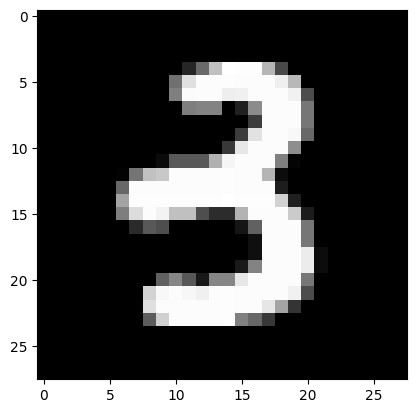

Predict:  tensor(3, device='cuda:0')
Correct:  tensor(3)


In [64]:
image_batch, label = next(iter(train_loader))

image_idx = 5

img = image_batch[image_idx, 0, :, :]
plt.imshow(img, 'gray')
plt.show()
img = img.to(device)
output = model(img)
pred = output.argmax(dim=1, keepdim=True)

print("Predict: ", pred[0, 0])
print("Correct: ", label[image_idx])